<a href="https://colab.research.google.com/github/aamanp/Final-Master-Project-Emotion-detection-in-audio/blob/main/Final_Master_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Final Master Project: emotion detection in audio**

In this work, we are going to use the RAVDESS dataset to analyse emotions in audios. To do so, we will train several machine learning models and the one with the best results will be compared with a Transformer.

First, we will make a description of the audios that make up the dataset using graphical elements as far as possible. Then, we will explain and detail the first model. Then, we will use a Transformer also to train the second model. Finally, we will make a comparison of both models. At the end of the work, we will emphasise the uses that this technology can have at a business level.

In the appendix we will indicate the different models used and their results, since for our first model, we have tested many ‘machine learning models’ until we found the best one.



The dataset was obtained from Kaggle (paper RAVDESS) and consists of 24 actors. In total there are 7356 audios.
The first 12 are men and the next 12 are women. The samples can be audio-video, video only or audio only. In our case, they will all be audio only. Each actor says two sentences twice and with two different intensities: normal and loud. The first sentence is ‘Kids are talking by the door’ and the second sentence is ‘Dogs are sitting by the door’. Each actor says the sentence expressing 8 emotions: neutral, calm, happy, sad, angry, scared, disgusted and surprised.
In order to better understand the organisation of the audios, here is an example:

The ‘03-01-06-01-02-02-23.wav’.

03-> mode: audio

01-> channel: spoken

06-> emotion: scared

01-> intensity: normal

02-> phrase: 2. ‘Dogs are sitting by the door’ 02-> repetition 2.

02-> repetition 2

23-> actor 23


A continuación, detallamos en esta Tabla la codificación de cada audio.
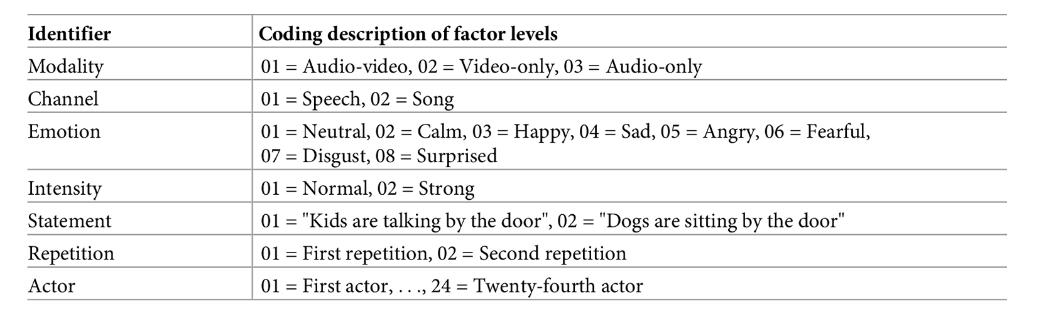


First we perform the imports and pip install of both the model and the Transformer. After that, we unzip and open the audios

In [ ]:
!pip uninstall -y tensorflow tensorflow-io-gcs-filesystem==0.37.1

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: tensorflow-io-gcs-filesystem 0.37.1
Uninstalling tensorflow-io-gcs-filesystem-0.37.1:
  Successfully uninstalled tensorflow-io-gcs-filesystem-0.37.1


In [ ]:
!pip install tensorflow==2.16.1 tensorflow-io==0.37.1  tf-keras==2.16.0 --quiet
!pip install transformers --quiet
!pip install librosa --quiet
!apt install git-lfs --quiet
!pip install scikit-learn --quiet
!pip install datasets[audio]==2.17.0 --no-deps --quiet
!pip install dill>=0.3.0 xxhash multiprocess --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.2 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 20.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.17.0 requires fsspec[http]<=2023.10.0,>=2023.1.0, but you have fsspec 2024.6.1 which is incompatible.


In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from google.colab import drive
import re
import librosa
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout
import matplotlib.pyplot as plt
import zipfile
from datasets import Dataset
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer, Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments
import tensorflow_io as tfio
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

We unzip the file to subsequently work on both models.

In [ ]:
!unzip -q "/content/drive/MyDrive/TFM/dataset_audio.zip" -d "/content/sample_data/dataset_audio"

With the following functions we prepare the dataset with which we will work later on.

In [ ]:
#Cargamos y convertimos el archivo de audio en un tensor
def load_audio(file_path):
    audio, _ = librosa.load(file_path, sr=16000)
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)
    return audio_tensor
#Con esta función re-muestreamos el audio a una tasa de 16.000 Hz. La tasa de muestreo es el número de muestras de audio que se toman por segundo.
#Cuando se graba un audio, se convierte la señal analógica en una señal digital por un proceso llamado muestreo.
def preprocess_audio(audio, target_sample_rate=16000):
    audio = tfio.audio.resample(audio, rate_in=tf.cast(audio.shape[0], tf.int64), rate_out=target_sample_rate)
    return audio
#Por ultimo almacenamos todos los archivos de audio en una nueva lista.
all_audio =[]
for root, dirs, files in os.walk("/content/sample_data/dataset_audio/dataset audio/audio_speech_actors_01-24", topdown=False):
   for name in files:
      all_audio.append(os.path.join(root, name))

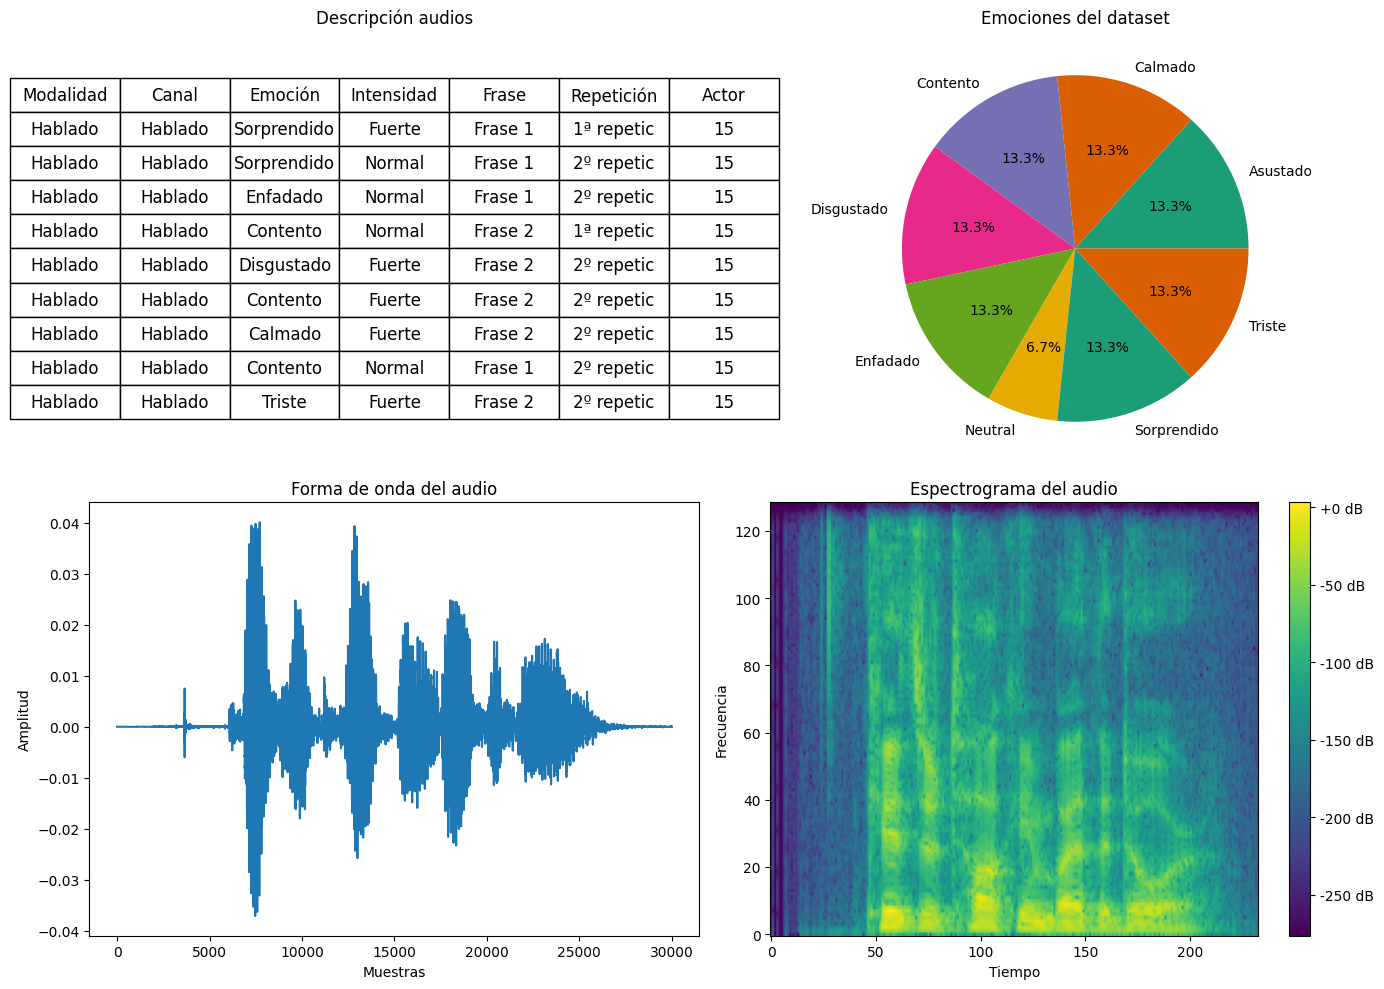

In [ ]:
# Configurar el tamaño de la figura donde realizaremos las graficas.
fig = plt.figure(figsize=(14, 10))

# Gráfico 1: Descripción de audios
# Procesamos todos los archivos de audio para extraer información descriptiva de cada audio y organizarla en un Dataframe
modalidad_map = {'03': 'Hablado'}
canal_map = {'01': 'Hablado', '02': 'Cantado'}
emocion_map = {
    '01': 'Neutral', '02':'Calmado', '03':'Contento', '04':'Triste',
    '05':'Enfadado', '06':'Asustado', '07':'Disgustado', '08':'Sorprendido'
}
intensidad_map = {'01':'Normal', '02':'Fuerte'}
frase_map = {'01':'Frase 1', '02':'Frase 2'}
repeticion_map = {'01': '1ª repetic', '02': '2º repetic'}

# Recorremos la carpeta y extraemos la información de los archivos.
data = []
for root, dirs, files in os.walk("/content/sample_data/dataset_audio/dataset audio/audio_speech_actors_01-24", topdown=False):
    for file in files:
        if file.endswith(".wav"):
            parts = os.path.basename(file).replace('.wav', '').split('-')
            if len(parts) == 7:
                modalidad = modalidad_map.get(parts[0], parts[0])
                canal = canal_map.get(parts[1], parts[1])
                emocion = emocion_map.get(parts[2], parts[2])
                intensidad = intensidad_map.get(parts[3], parts[3])
                frase = frase_map.get(parts[4], parts[4])
                repeticion = repeticion_map.get(parts[5], parts[5])
                actor = parts[6]
                data.append([modalidad, canal, emocion, intensidad, frase, repeticion, actor])

# Creamos el DataFrame
columns = ['Modalidad', 'Canal', 'Emoción', 'Intensidad', 'Frase', 'Repetición', 'Actor']
df = pd.DataFrame(data, columns=columns)

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.axis('tight')
ax1.axis('off')
ax1.set_title('Descripción audios')
table = ax1.table(cellText=df.head(9).values, colLabels=df.columns, cellLoc = 'center', loc='center')
table.scale(1.1, 1.1)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
for key, cell in table.get_celld().items():
    cell.set_width(0.18)

# Gráfico 2: Gráfica circular en la posición (0, 1)
ax2 = plt.subplot2grid((2, 2), (0, 1))
df.groupby('Emoción').size().plot(kind='pie', autopct='%1.1f%%', colors=sns.palettes.mpl_palette('Dark2'), ax=ax2)
ax2.set_aspect('equal')
ax2.set_title("Emociones del dataset")

# Gráfico 3: Forma de onda en la posición (1, 0)
audio = load_audio("/content/drive/MyDrive/TFM/dataset_audio/Actor_01/03-01-01-01-01-01-01.wav")
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax3.plot(audio[10000:40000])
ax3.set_title('Forma de onda del audio')
ax3.set_xlabel('Muestras')
ax3.set_ylabel('Amplitud')

# Gráfico 4: Espectrograma en la posición (1, 1)
audio_subset = audio[10000:40000]
stft = tf.signal.stft(audio_subset, frame_length=256, frame_step=128)
spectrogram = tf.abs(stft)
spectrogram = 20 * tf.math.log(spectrogram + 1e-6)

ax4 = plt.subplot2grid((2, 2), (1, 1))
im = ax4.imshow(tf.transpose(spectrogram), origin='lower', aspect='auto', cmap='viridis')
fig.colorbar(im, ax=ax4, format='%+2.0f dB')
ax4.set_title('Espectrograma del audio')
ax4.set_xlabel('Tiempo')
ax4.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

The interpretation of the first two upper graphs is easier and clearer to understand. In the table, we can see a sample of our dataset. Each emotion is repeated several times, depending on the intensity, the phrase that is said and the repetition. In the pie chart, we can see that all the emotions represent 13.3% of the dataset, except the neutral emotion, which leads us to think that predicting this emotion will be more difficult for our model, as it does not have enough training data.
The third figure, the audio waveform, shows how the amplitude of the signal varies over 2 seconds.  As the sampling frequency is 16,000Hz, each 16,000 represents one second, i.e. we have 32,000 samples (16,000 x 2 seconds).
The last figure is a spectrogram, a visual representation of the sound that shows how its frequency content changes over time. Every 128 samples of the audio wave graph, we generate a column in the spectrogram. Lighter colours represent louder tones or noise and darker colours represent silences. Spectrograms represent the way our ears perceive sound. This is why they are used to train models, as they offer a more human perception of sound, which hopefully facilitates the learning of the model.

**MELSPECTROGRAM**

In [ ]:
#El siguiente codigo extrae las etiquedas de cada archivo y las almacena en una lista llamada labels.
#Después, convertimos esas etiquetas en one-hot encoded, ya que es una representación adecuada para entrenar nuestro modelo de aprendizaje automatico de clasificación.
audio_files = all_audio
labels =[]

for i in audio_files:
  labels.append(int(i[-18:-16]))

audio_files = audio_files
labels = labels

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
labels = to_categorical(integer_encoded)

We will make the training-test division on the basis of the actors. The actor samples 1 to 19 will be the training samples and 20 to 24 will be the test samples.

In [ ]:
#Dividiremos los archivos de audio en entrenamiento y prueba. Después crearemos generadores para cargar y preprocesar los datos en tiempo real.
train_audio_files = []
train_labels = []
test_audio_files = []
test_labels = []

for i, file in enumerate(audio_files):
  actor_id = int(file[-6:-4])
  if actor_id <= 19:
    train_audio_files.append(file)
    train_labels.append(labels[i])
  else:
    test_audio_files.append(file)
    test_labels.append(labels[i])
def train_generator():
    for file, label in zip(train_audio_files, train_labels):
        audio = load_audio(file)
        audio = preprocess_audio(audio)
        audio = tf.keras.preprocessing.sequence.pad_sequences([audio], maxlen=64000, dtype='float32', padding='post', truncating='post')[0]
        yield audio, label

def test_generator():
    for file, label in zip(test_audio_files, test_labels):
        audio = load_audio(file)
        audio = preprocess_audio(audio)
        audio = tf.keras.preprocessing.sequence.pad_sequences([audio], maxlen=64000, dtype='float32', padding='post', truncating='post')[0]
        yield audio, label

train_dataset = tf.data.Dataset.from_generator(train_generator, output_signature=(
    tf.TensorSpec(shape=(64000,), dtype=tf.float32),
    tf.TensorSpec(shape=(8,), dtype=tf.float32)
))

test_dataset = tf.data.Dataset.from_generator(test_generator, output_signature=(
    tf.TensorSpec(shape=(64000,), dtype=tf.float32),
    tf.TensorSpec(shape=(8,), dtype=tf.float32)
))

train_dataset = train_dataset.cache().shuffle(buffer_size=100)
test_dataset = test_dataset.cache().batch(16)

# Con estas funciones agregamos ruido aleatorio para prevenir el overfiting ya que se lo ponemos más difícil al modelo durante el aprendizaje.
#También añadimos desplazamiento temporal para simular variaciones en la sincronización y que no aprenda a generalizar los audios.

def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data.astype(np.float32)

def time_shift(data, shift_max=0.2):
    shift = np.random.randint(int(len(data) * shift_max))
    return np.roll(data, shift).astype(np.float32)

def apply_data_augmentation(audio, label):
  ad_shape = audio.shape
  audio = tf.numpy_function(add_noise, [audio], tf.float32)
  audio.set_shape(ad_shape)

  ad_shape = audio.shape
  audio = tf.numpy_function(time_shift, [audio], tf.float32)
  audio.set_shape(ad_shape)


  return audio, label

train_dataset_augmented = train_dataset.map(apply_data_augmentation)


In [ ]:
#Entrenaremos un modelo de red neuronal secuencial utilizando TensorFow/Keras, enfocado en el procesamiento de audio, específicamente en la clasificación de señales de audio basadas en espectrogramas.
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None,)),
    tf.keras.layers.MelSpectrogram(
        fft_length=1024,
        sequence_stride=256,
        sequence_length=512,
        window='hann',
        sampling_rate=16000,
        num_mel_bins=128,
        power_to_db=False
),
    tf.keras.layers.Reshape((128, 251)),
    tf.keras.layers.Permute((2,1)),
    tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.3),
    tf.keras.layers.LSTM(128, return_state=False, go_backwards=True, dropout=0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#Imprimiremos el progreso del entrenamiento cada 10 epochs.
class Callback(tf.keras.callbacks.Callback):
    SHOW_NUMBER = 10
    epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

    def on_epoch_end(self, epoch, logs=None):
      if self.epoch % self.SHOW_NUMBER == 0:
        print('Epoch: ' + str(self.epoch + 1) + ' accuracy: ' + str(logs['accuracy']), 'val_accuracy: ' + str(logs['val_accuracy']))


model.fit(train_dataset_augmented.batch(16), validation_data=test_dataset, callbacks=[Callback()], verbose=0, epochs=240)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mel_spectrogram_1 (MelSpectrogram)   │ (None, 128, None)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 128, 251)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute_1 (Permute)                  │ (None, 251, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 251, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,224 (1.13 MB)

 Trainable params: 297,224 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch: 1 accuracy: 0.13245613873004913 val_accuracy: 0.13333334028720856
Epoch: 11 accuracy: 0.20350876450538635 val_accuracy: 0.24666666984558105
Epoch: 21 accuracy: 0.224561408162117 val_accuracy: 0.2566666603088379
Epoch: 31 accuracy: 0.24210526049137115 val_accuracy: 0.23666666448116302
Epoch: 41 accuracy: 0.2271929830312729 val_accuracy: 0.25
Epoch: 51 accuracy: 0.23245614767074585 val_accuracy: 0.25333333015441895
Epoch: 61 accuracy: 0.23333333432674408 val_accuracy: 0.2433333396911621
Epoch: 71 accuracy: 0.269298255443573 val_accuracy: 0.2666666805744171
Epoch: 81 accuracy: 0.2728070318698883 val_accuracy: 0.2633333206176758
Epoch: 91 accuracy: 0.2885964810848236 val_accuracy: 0.3033333420753479
Epoch: 101 accuracy: 0.3236842155456543 val_accuracy: 0.27000001072883606
Epoch: 111 accuracy: 0.32192981243133545 val_accuracy: 0.30000001192092896
Epoch: 121 accuracy: 0.35350877046585083 val_accuracy: 0.33666667342185974
Epoch: 131 accuracy: 0.3649122714996338 val_accuracy: 0.34666666

In [ ]:
# Realizamos nuestras predicciones y las compararemos con las etiquetas correctas.
prediction = model.predict(test_dataset)
prediction.argmax(axis=1)

etiquetas = {
    0: "neutral",
    1: "calmado",
    2: "contento",
    3: "triste",
    4: "enfadado",
    5: "asustado",
    6: "disgustado",
    7: "sorprendido"
}
prediccion_MelSpectrogram = [etiquetas[numero] for numero in prediction.argmax(axis=1)]
test_labels_MelSpectrogram = [etiquetas[numero] for numero in np.array([np.argmax(label) for label in test_labels])]
print(prediccion_MelSpectrogram[1:20])
print(test_labels_MelSpectrogram[1:20])


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
['asustado', 'calmado', 'contento', 'enfadado', 'contento', 'disgustado', 'calmado', 'asustado', 'enfadado', 'disgustado', 'enfadado', 'asustado', 'contento', 'enfadado', 'contento', 'disgustado', 'disgustado', 'contento', 'disgustado']
['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral']


We can see that our model has a very low accuracy of 36.66%. We can also see that many of the predictions do not correspond to the correct labels.

We will train the second model and then make a graphical comparison between the two.

**TRANSFORMER**

We take the pre-trained Wav2Vec2 model for ASR (Automatic Speech Recognition) which has been trained with over 50,000 hours of unlabelled audio. In this case, instead of ASR we will use the model for emotion detection, as it will have learned to process speech during pre-training. The model is composed of a convolutional network in its first layer that transforms the audio into feature representations. It then uses transformers that learn dependencies and relationships in the audio data.

In [ ]:
#Cargamos los archivos de audio.
def load_audio2(file_path):
    audio, _ = librosa.load(file_path, sr=16000)
    return audio

In [ ]:
#Cargamos y convertimos en formato tensor los datos de audio y los separamos en un conjunto de entrenamiento y test.
train_audio = []
train_labels = []
test_audio = []
test_labels = []

for root, dirs, files in os.walk("/content/sample_data/dataset_audio/dataset audio/audio_speech_actors_01-24", topdown=False):
   for name in files:
      file_path = os.path.join(root, name)
      audio_tensor = load_audio2(file_path)
      actor_id = int(file_path[-6:-4])
      labels= int(file_path[-18:-16]) - 1
      if actor_id <= 19:
          train_audio.append(audio_tensor)
          train_labels.append(labels)
      else:
          test_audio.append(audio_tensor)
          test_labels.append(labels)

print(train_audio[0])
print(train_labels[0:5])
train = Dataset.from_dict({"audio": train_audio, "label": train_labels})
test =  Dataset.from_dict({"audio": test_audio, "label": test_labels})

[-2.2295391e-05 -4.5707293e-05 -4.8107351e-05 ... -8.6057204e-05
  6.1802228e-04  3.1781069e-04]
[6, 5, 4, 1, 3]


In [ ]:
#Utilizaremos la clase AutoFeatureExtractor de la librería Hugging Face Transformer para cargar un extractor de características preentrenadas.
#Así, convertimos el audio en un formato que pueda ser procesado por el modelo Wav2Vec2.
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

In [ ]:
# Definimos una funcion para preparar los audios para el modelo Wav2Vec2.
max_duration = 4
def preprocess_function(examples):
    audio_arrays = examples["audio"]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    return inputs

In [ ]:
#El código preprocesa los datos de audio, los transforma en características que el modelo puede entender y carga el modelo preentrenado.
encoded_train = train.map(preprocess_function, remove_columns=["audio"], batched=True)
encoded_test = test.map(preprocess_function, remove_columns=["audio"], batched=True)
num_labels = 8
model_auto = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-large",
    num_labels=num_labels,
)

Map:   0%|          | 0/1140 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Definimos los argumentos de entrenamiento. Los parámetros del objeto Training Arguments controlan la tasa de aprendizaje, el tamaño de batch, las estrategias de evaluación y guardado.
model_name = "facebook/wav2vec2-large".split("/")[-1]
batch_size = 8
args = TrainingArguments(
    f"{model_name}-finetuned-ks",
    eval_strategy = "steps",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    fp16=True,
    save_steps=500,
    eval_steps=500,
    weight_decay=0.005,
    warmup_steps=1000,
    save_total_limit=2,
)

# Definimos una función para medir que tan bien esta funcionando el modelo en la tarea de clasificación.
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return {"accuracy": accuracy_score(eval_pred.label_ids, predictions)}

# El objeto Trainer facilita el proceso de entrenamiento y evaluación y permite automatizar varias tareas.
trainer = Trainer(
    model_auto,
    args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
#Entrenamos el modelo y generamos las predicciones para el conjunto de test
trainer.train()
prediccion= trainer.predict(encoded_test)
labels_model=prediccion.predictions.argmax(axis=1)
true_labels= prediccion.label_ids
prediccion_text = [etiquetas[numero] for numero in labels_model]
test_labels_text = [etiquetas[numero] for numero in true_labels]
print(prediccion_text[1:20])
print(test_labels_text[1:20])
print(accuracy_score(test_labels_text, prediccion_text))

['calmado', 'asustado', 'calmado', 'sorprendido', 'enfadado', 'enfadado', 'disgustado', 'triste', 'disgustado', 'enfadado', 'enfadado', 'neutral', 'calmado', 'triste', 'calmado', 'contento', 'enfadado', 'disgustado', 'calmado']
['calmado', 'asustado', 'triste', 'sorprendido', 'enfadado', 'enfadado', 'disgustado', 'triste', 'disgustado', 'enfadado', 'enfadado', 'neutral', 'triste', 'triste', 'calmado', 'contento', 'enfadado', 'disgustado', 'neutral']
0.7633333333333333


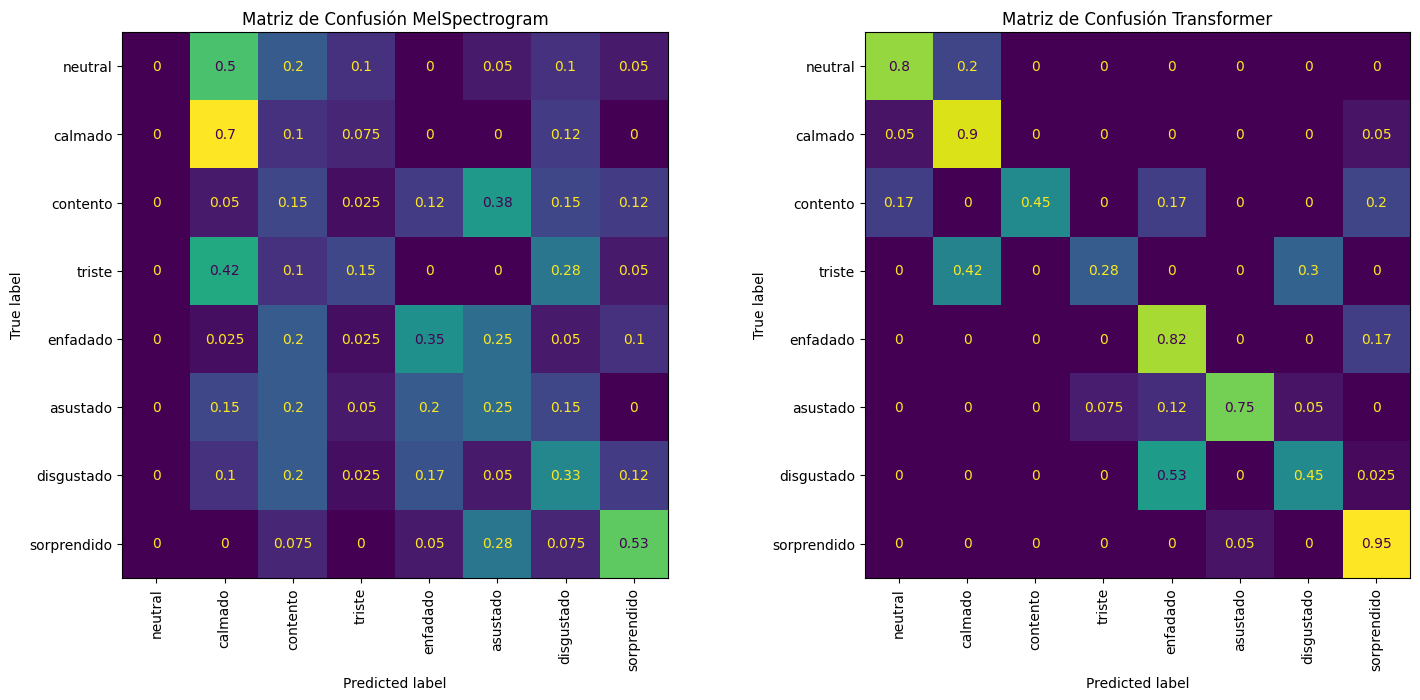

In [ ]:
#Vamos a comparar los resultados utilizando una matriz de Confusión.
cm_mel = confusion_matrix(test_labels_MelSpectrogram, prediccion_MelSpectrogram, normalize='true',
                           labels=['neutral', 'calmado', 'contento', 'triste', 'enfadado', 'asustado', 'disgustado', 'sorprendido'])
cm_text = confusion_matrix(test_labels_text, prediccion_text, normalize='true',
                            labels=['neutral', 'calmado', 'contento', 'triste', 'enfadado', 'asustado', 'disgustado', 'sorprendido'])

# Crear las visualizaciones
disp_mel = ConfusionMatrixDisplay(confusion_matrix=cm_mel, display_labels=['neutral', 'calmado', 'contento', 'triste', 'enfadado', 'asustado', 'disgustado', 'sorprendido'])
disp_text = ConfusionMatrixDisplay(confusion_matrix=cm_text, display_labels=['neutral', 'calmado', 'contento', 'triste', 'enfadado', 'asustado', 'disgustado', 'sorprendido'])

# Crear la figura y los ejes
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plotear la primera matriz de confusión
disp_mel.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Matriz de Confusión MelSpectrogram')
axes[0].set_xticklabels(disp_mel.display_labels, rotation=90)


# Plotear la segunda matriz de confusión
disp_text.plot(ax=axes[1], colorbar= False)
axes[1].set_title('Matriz de Confusión Transformer')
axes[1].set_xticklabels(disp_text.display_labels, rotation=90)


# Ajustar el layout y mostrar
plt.tight_layout()
plt.show()

The confusion matrix allows us to evaluate the performance of both models. On the diagonal we can find the emotions that have been correctly predicted.

The MelSpectrogram model has a good ability to predict the emotions calm, surprised and angry, with 0.78, 0.47 and 0.38 correct. However, we note that in general it does not perform well. Here we can highlight that despite having trained the model, the neurons, or parameters, have not learned well enough to make the correct predictions. This can be seen in the off-diagonal values, which have a tendency to predict quite a lot of incorrect emotions.  

In contrast, we can clearly see that the Transformer has a far superior predictive ability. Although it predicts some emotions wrongly, the hits are much higher than in the first model. The emotion calm predicts it perfectly, followed by surprised, angry, scared and disgusted. This model has been trained with 317 million parameters, which means that although it has little fine tuning training data, the weights of the values are able to make correct predictions.

From this analysis, we can highlight the importance of having sufficient training data. The model trained from 0 has not been able to perform adequately. On the other hand, the pre-trained Transformer models with a lot of data are able to perform well even with little training data.



**PRODUCTION**

What is the use of this type of model, in which tasks or how can we make this model productive? Emotion analysis allows companies to improve their relationship with their customers. For example, analysing conversations with customers allows us to offer better solutions or services that increase customer satisfaction. We can also analyse reactions to marketing campaigns. Especially in social media we can measure the reputation of a brand.

We want to show how the model would be used to integrate it into a product. In this case we only need an audio file to tag. We will try an audio that I have recorded myself. The emotion of the audio is neutral, let's check what predictions both models give us.

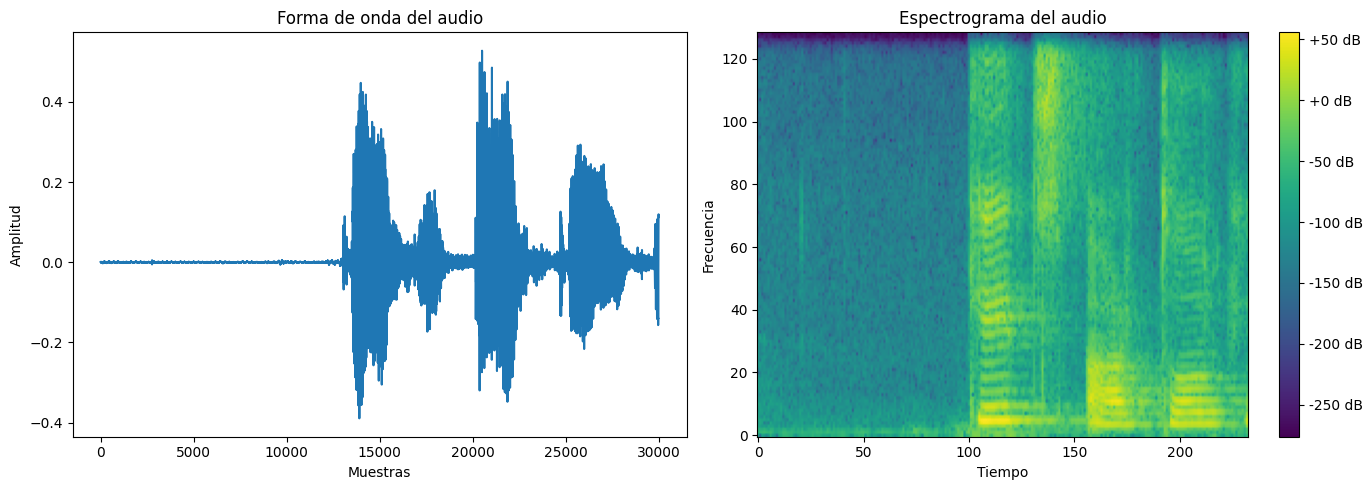

In [ ]:
audio_trial = load_audio("/content/drive/MyDrive/TFM/trial.wav")

audio_trial_segment = audio_trial[10000:40000]
stft = tf.signal.stft(audio_trial_segment, frame_length=256, frame_step=128)
spectrogram = tf.abs(stft)
spectrogram_db = 20 * tf.math.log(spectrogram + 1e-6)

# Crear una figura con dos subgráficas en una fila
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Graficar la forma de onda en el primer subgrafico
ax1.plot(audio_trial_segment)
ax1.set_title('Forma de onda del audio')
ax1.set_xlabel('Muestras')
ax1.set_ylabel('Amplitud')

# Graficar el espectrograma en el segundo subgrafico
im = ax2.imshow(np.transpose(spectrogram_db), aspect='auto', origin='lower', cmap='viridis')
ax2.set_title('Espectrograma del audio')
ax2.set_xlabel('Tiempo')
ax2.set_ylabel('Frecuencia')

# Añadir la barra de colores para el espectrograma
fig.colorbar(im, ax=ax2, format='%+2.0f dB')

plt.tight_layout()
plt.show()

We can observe that both the shape of the audio and the spectrogram is very different from the training set. It is important to note that the training sets are prepared under very well thought out and prepared conditions. We can notice that the audio I have recorded has not followed the guidelines of rigorous recording control, which is a challenge for the models.

In [ ]:
#Prediccion con Espectrograma: grabo audio neutral, modelo dice contento

audio = preprocess_audio(audio_trial)
print(audio, type(audio))
audio = tf.keras.preprocessing.sequence.pad_sequences([audio], maxlen=64000, dtype='float32', padding='post', truncating='post')[0]
audio = audio.reshape(1, -1)
audio = tf.convert_to_tensor(audio)
print(audio, type(audio))

model(audio).numpy().argmax(axis=1)

tf.Tensor(
[ 2.7080126e-11  4.4355436e-10 -1.4986705e-09 ...  2.2096766e-04
  5.3081737e-04  2.3792745e-04], shape=(16000,), dtype=float32) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 2.7080126e-11  4.4355436e-10 -1.4986705e-09 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]], shape=(1, 64000), dtype=float32) <class 'tensorflow.python.framework.ops.EagerTensor'>


array([5])

In [ ]:
#Prediccion Transformer: grabo audio neutral, modelo dice calmado

audio_arrays = audio_trial
inputs = feature_extractor(
  audio_arrays,
  sampling_rate=feature_extractor.sampling_rate,
  max_length=int(feature_extractor.sampling_rate * max_duration),
  truncation=True,
  return_tensors="pt")

prediccion=trainer.model(inputs['input_values'].to(trainer.model.device))
#logits.argmax(axis=1)
print('La predicción del Transformer es: '+str(prediccion.logits.argmax(axis=1)))

La predicción del Transformer es: tensor([1], device='cuda:0')


We can see that the production set-up is very simple in both models. In the future, it could be improved by creating a web server that receives the uploaded audio and returns the prediction, but this example sufficiently demonstrates how it can be done.

Here are the different models we have used:

In [ ]:
"""
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None,)),  # The input shape is variable-length sequences
    tf.keras.layers.Reshape((64000, 1)),  # Reshape to (sample_rate, 1)
    tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(train_dataset.batch(16).prefetch(4), validation_data=test_dataset, epochs=60)

In [ ]:
"""
model1d = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64000, 1)),  # The input shape is variable-length sequences
    tf.keras.layers.GroupNormalization(groups=-1),
    tf.keras.layers.Conv1D(32, 32, padding='same', activation='relu', strides=2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(32, 8, padding='same', activation='relu', strides=2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu', strides=2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(128, 8, padding='same', activation='relu', strides=2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model1d.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model1d.summary()
model1d.fit(train_dataset.batch(16), validation_data=test_dataset, epochs=240)

In [ ]:
"""
model1dspec =  tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None,)),
    #tf.keras.layers.Reshape((64000, 1)),
    tf.keras.layers.MelSpectrogram(
        fft_length=1024,
        sequence_stride=256,
        sequence_length=512,
        window='hann',
        sampling_rate=16000,
        num_mel_bins=128,
        power_to_db=False
),
    tf.keras.layers.Reshape((128, 251)),
    tf.keras.layers.Permute((2,1)),
    tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model1dspec.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model1dspec.summary()
model1dspec.fit(train_dataset_augmented.batch(16), validation_data=test_dataset, epochs=240)


In [ ]:
"""
# Nuevo modelo, con una tf.keras.layers.MelSpectrogram después del reshape, y luego tiene que tener Conv2D en vez de Conv1D
model1 =  tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None,)),
    #tf.keras.layers.Reshape((64000, 1)),
    tf.keras.layers.MelSpectrogram(
        fft_length=1024,
        sequence_stride=256,
        sequence_length=512,
        window='hann',
        sampling_rate=16000,
        num_mel_bins=128,
        power_to_db=True
),
    tf.keras.layers.Reshape((128, 251, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])
